# **Predicting credit risk for a bank customer**


# **1. Dataset description**

<b>German credit data: </b></br>
<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text - little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in months)<br>
<b>Purpose</b>(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)<br>
<b>Risk </b> (Value target - Good or Bad Risk)<br>

<a id="Libraries"></a> <br>
# **2. Libraries and data**

In [1]:
import warnings
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
link = 'https://drive.google.com/file/d/1w6YFhjiFCruL_EHyN125nT4nPplqm1nm/view?usp=sharing'

id = link.split("/")[-2]
filename= 'german_credit_data.csv'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(filename)

In [7]:
df_credit = pd.read_csv(filename, index_col=0)

<a id="Known"></a> <br>
# **3. First look at the data**

In [8]:
#Searching for null values,data types and shape
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [9]:
#Looking at unique values
df_credit.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

In [11]:
#Looking at a data sample
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [12]:
# Looking at the target variable to identify imbalance
df_credit['Risk'].value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

# **4. Feature Engineering** <a id="Feature Engineering"></a> <br>

## Null treatement

In [13]:
# Null treatement
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

## Treatement of Categorical variables

In [15]:
# categ = list(df_credit.select_dtypes(['object']).columns | df_credit.select_dtypes(['category']).columns)
# print(categ)
object_columns = df_credit.select_dtypes(['object']).columns
category_columns = df_credit.select_dtypes(['category']).columns

if object_columns.empty:
    categ = list(category_columns)
elif category_columns.empty:
    categ = list(object_columns)
else:
    categ = list(object_columns | category_columns)

print(categ)

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']


In [16]:
# One hot encoder for Categorical Variables
print('Data frame shape before Categorical Values encoding: ',df_credit.shape)
df_credit = pd.get_dummies(data=df_credit, columns=categ)
print('Data frame shape after Categorical Values encoding: ',df_credit.shape)
del df_credit['Risk_good']

Data frame shape before Categorical Values encoding:  (1000, 10)
Data frame shape after Categorical Values encoding:  (1000, 28)


In [17]:
df_credit.head()

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_bad
0,67,2,1169,6,False,True,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
1,22,2,5951,48,True,False,False,True,False,True,...,False,False,False,False,False,False,True,False,False,True
2,49,1,2096,12,False,True,False,True,False,True,...,False,False,False,False,True,False,False,False,False,False
3,45,2,7882,42,False,True,True,False,False,True,...,False,False,False,False,False,True,False,False,False,False
4,53,2,4870,24,False,True,True,False,False,True,...,False,False,True,False,False,False,False,False,False,True


## Looking at the correlation of the data

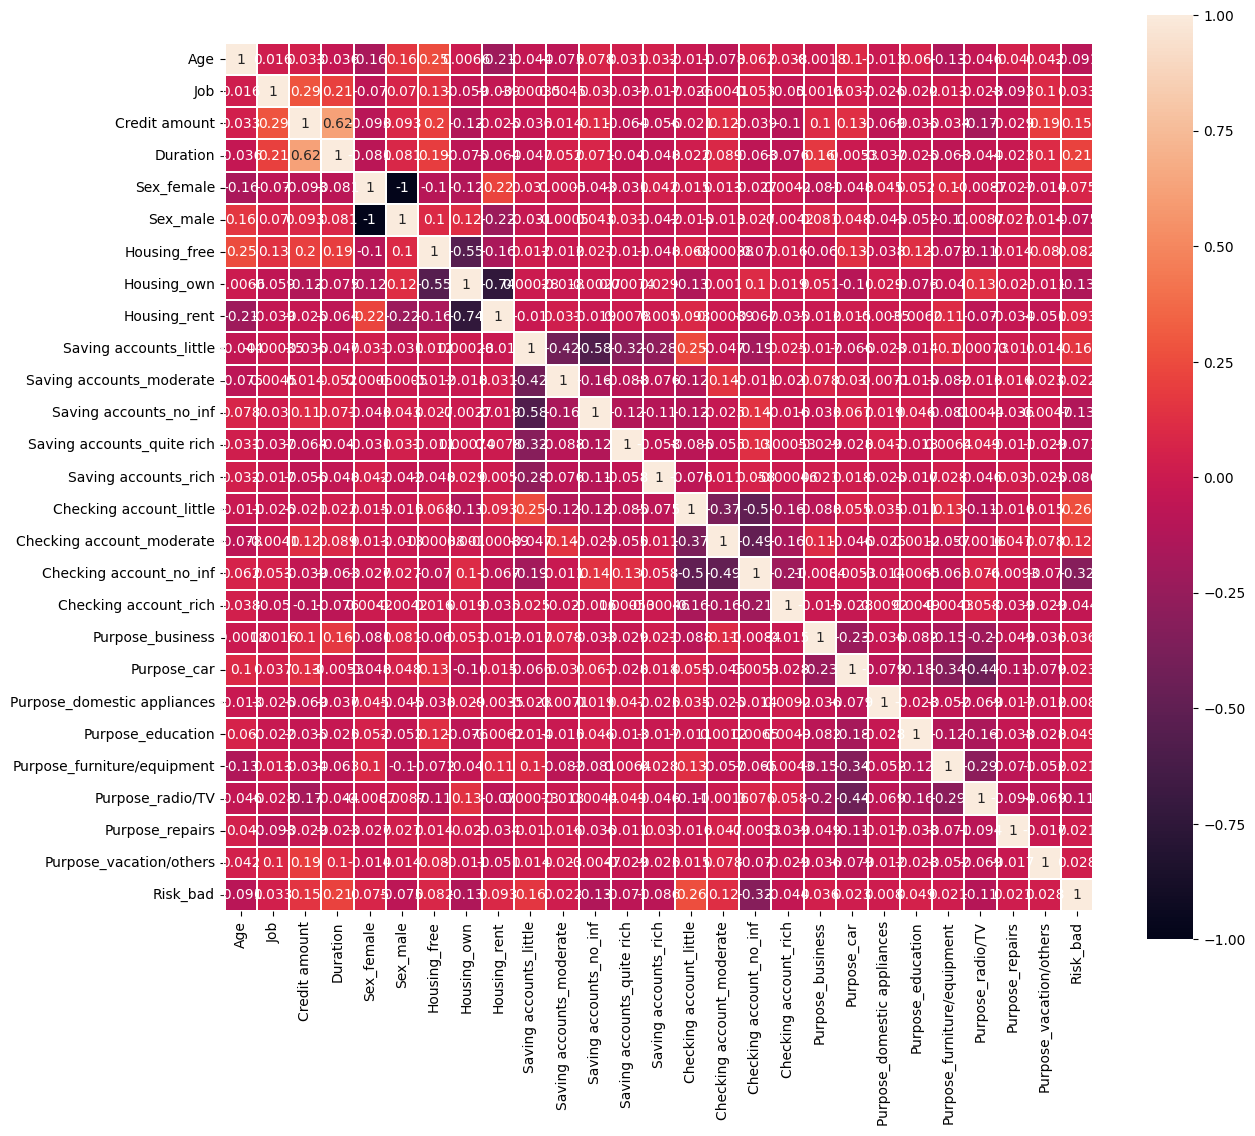

In [18]:
plt.figure(figsize=(14,12))
sns.heatmap(df_credit.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,  linecolor='white', annot=True)
plt.show()

In [19]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [20]:
corr_features = correlation(df_credit, 0.9)
print(corr_features)

for column in corr_features:
  df_credit.drop(column, axis=1,inplace=True)

{'Sex_male'}


# **5. Train/Test split and Scaling** <a id="Train/Test split and Scaling"></a> <br>


## Import libraries

In [22]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, classification_report, fbeta_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

## Prepare and split Dataset into Train and Test

In [23]:
target = 'Risk_bad'
predictor = df_credit.drop([target], axis=1).columns

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_credit[predictor], df_credit[target], test_size = 0.2, random_state=42)

## Scale input for distance-based models (Logistic Regression, KMeans, Support Vector Classifier)

In [24]:
min_max_scaler = preprocessing.MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

# **6. Implement models** <a id="Implement models"></a> <br>

### Define model evaluation functions

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/


In [25]:
# Evaluate results based on the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(y_test, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', cmap='Blues')
  plt.show()

In [26]:
# Evaluate model performance
def clasif_report(y_test,y_pred):
  print(classification_report(y_test, y_pred))

In [27]:
# Determine model robustness
def roc_auc(model, X_train, y_train, y_test, y_pred, n_splits):
  roc_auc_test = metrics.roc_auc_score(y_test, y_pred, average='micro')
  roc_auc_cv = cross_val_score(estimator = model, X = X_train, y = y_train, scoring = 'roc_auc', cv = n_splits)
  roc_auc_cv_mean = roc_auc_cv.mean()
  roc_auc_cv_std = roc_auc_cv.std()

  print('Test ROC AUC           : {:.4f}'.format(roc_auc_test))
  print('Cross-val ROC AUC mean : {:.4f}'.format(roc_auc_cv_mean))
  print('Cross-val ROC AUC std  : {:.4f}'.format(roc_auc_cv_std))

In [28]:
#Plotting the ROC curve
def plot_roc_curve(model, X_test, y_test):
  y_pred_prob = model.predict_proba(X_test)[:,1]              # Predict probabilities
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)       # Generate ROC curve values: fpr, tpr, thresholds

  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

### Logistic Regression

In [29]:
# import libraries
from sklearn.linear_model import LogisticRegression

In [30]:
# train the model
model_LR = LogisticRegression(random_state=42, C=10)
model_LR.fit(X_train_scaled, y_train)

LogisticRegression(C=10, random_state=42)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [31]:
# predict on test data
y_pred = model_LR.predict(X_test_scaled)

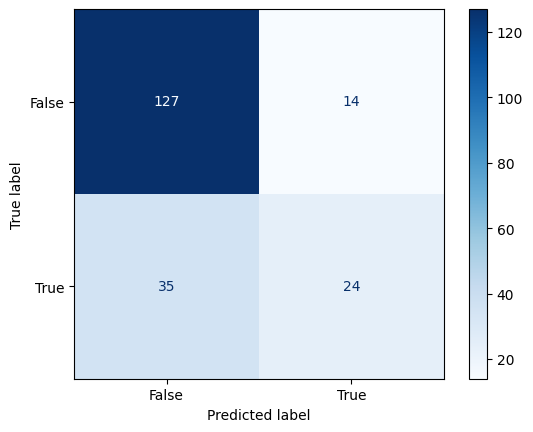

In [32]:
# Evaluate results based on the confusion matrix
plot_cm(y_test,y_pred)

In [33]:
# Evaluate model performance
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

       False       0.78      0.90      0.84       141
        True       0.63      0.41      0.49        59

    accuracy                           0.76       200
   macro avg       0.71      0.65      0.67       200
weighted avg       0.74      0.76      0.74       200



In [34]:
# Determine model robustness
roc_auc(model_LR, X_train_scaled, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6537
Cross-val ROC AUC mean : 0.7537
Cross-val ROC AUC std  : 0.0404


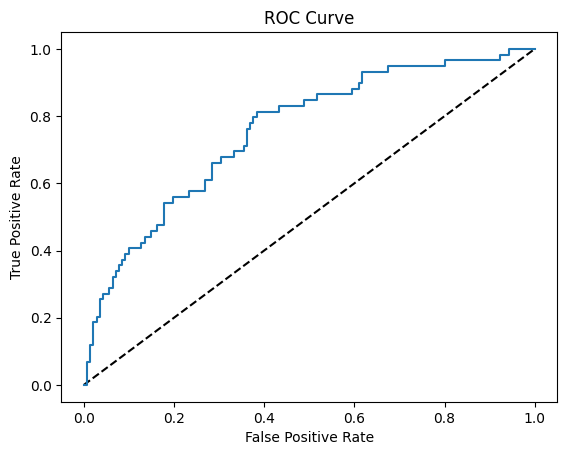

In [35]:
#Plotting the ROC curve
plot_roc_curve(model_LR, X_test_scaled, y_test)

In [37]:
# Print intercept and coefficients
print ('Model intercept: '+str(model_LR.intercept_))

# model coefficients
odds = np.exp(model_LR.coef_[0])
pd.DataFrame(odds,
             X_train.columns,
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

# For every one-unit increase in [X variable], the odds that the observation is
# in (y class) are [coefficient] times as large as the odds that the observation
# is not in (y class) when all other variables are held constant

Model intercept: [-1.32487764]


,coef
Duration,4.860524
Checking account_little,2.215383
Credit amount,1.762553
Purpose_education,1.694978
Sex_female,1.483401
Job,1.472171
Saving accounts_moderate,1.450664
Saving accounts_little,1.449320
Checking account_moderate,1.395074
Housing_free,1.317075


### K-Nearest Neighbors Classifier

In [38]:
# import libraries
from sklearn.neighbors import KNeighborsClassifier

In [39]:
# train the model
model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train_scaled, y_train)

KNeighborsClassifier()

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [40]:
# predict on test data
y_pred = model_KNN.predict(X_test_scaled)

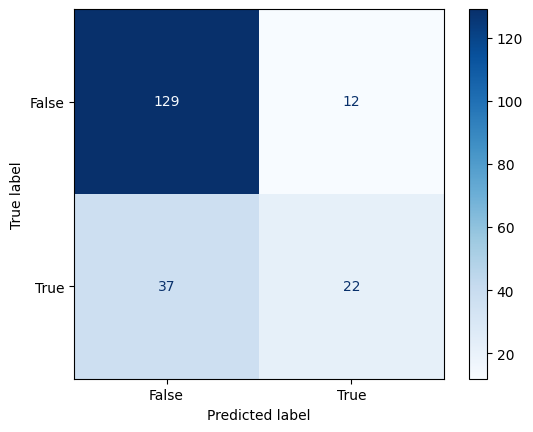

In [41]:
# Evaluate results based on the confusion matrix
plot_cm(y_test,y_pred)

In [42]:
# Evaluate model performance
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

       False       0.78      0.91      0.84       141
        True       0.65      0.37      0.47        59

    accuracy                           0.76       200
   macro avg       0.71      0.64      0.66       200
weighted avg       0.74      0.76      0.73       200



In [43]:
# Determine model robustness
roc_auc(model_KNN, X_train_scaled, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6439
Cross-val ROC AUC mean : 0.6845
Cross-val ROC AUC std  : 0.0462


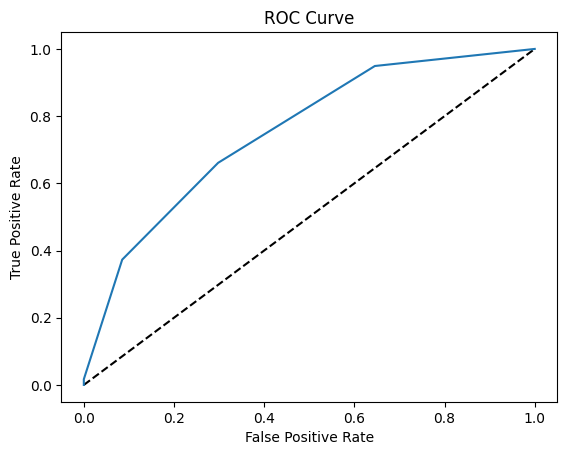

In [44]:
#Plotting the ROC curve
plot_roc_curve(model_KNN, X_test_scaled, y_test)

### Decision Tree Classifier

In [45]:
# import libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [46]:
# train the model
model_DT = DecisionTreeClassifier(max_depth=4, random_state=42)
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [47]:
# predict on test data
y_pred = model_DT.predict(X_test)

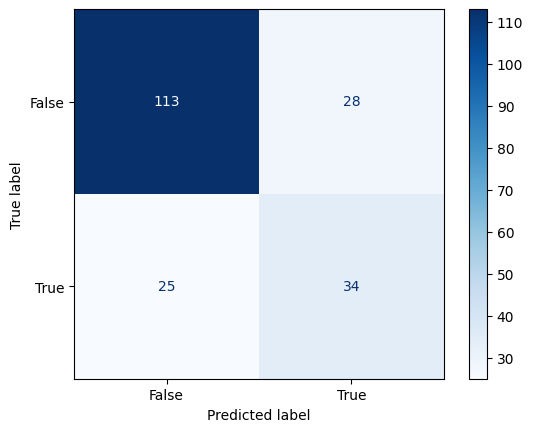

In [48]:
# Evaluate results based on the confusion matrix
plot_cm(y_test,y_pred)

In [49]:
# Evaluate model performance
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

       False       0.82      0.80      0.81       141
        True       0.55      0.58      0.56        59

    accuracy                           0.73       200
   macro avg       0.68      0.69      0.69       200
weighted avg       0.74      0.73      0.74       200



In [50]:
# Determine model robustness
roc_auc(model_DT, X_train, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6888
Cross-val ROC AUC mean : 0.6806
Cross-val ROC AUC std  : 0.0370


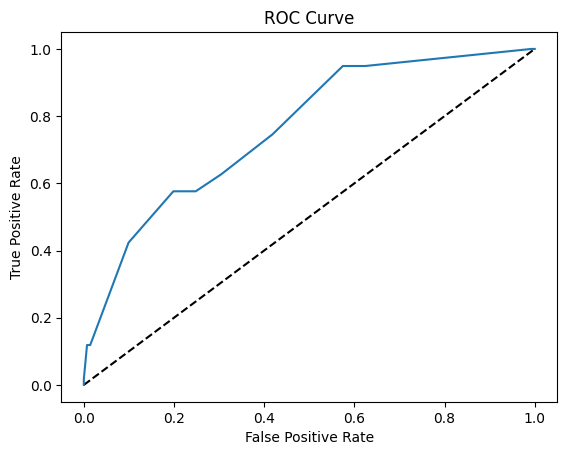

In [51]:
#Plotting the ROC curve
plot_roc_curve(model_DT, X_test, y_test)

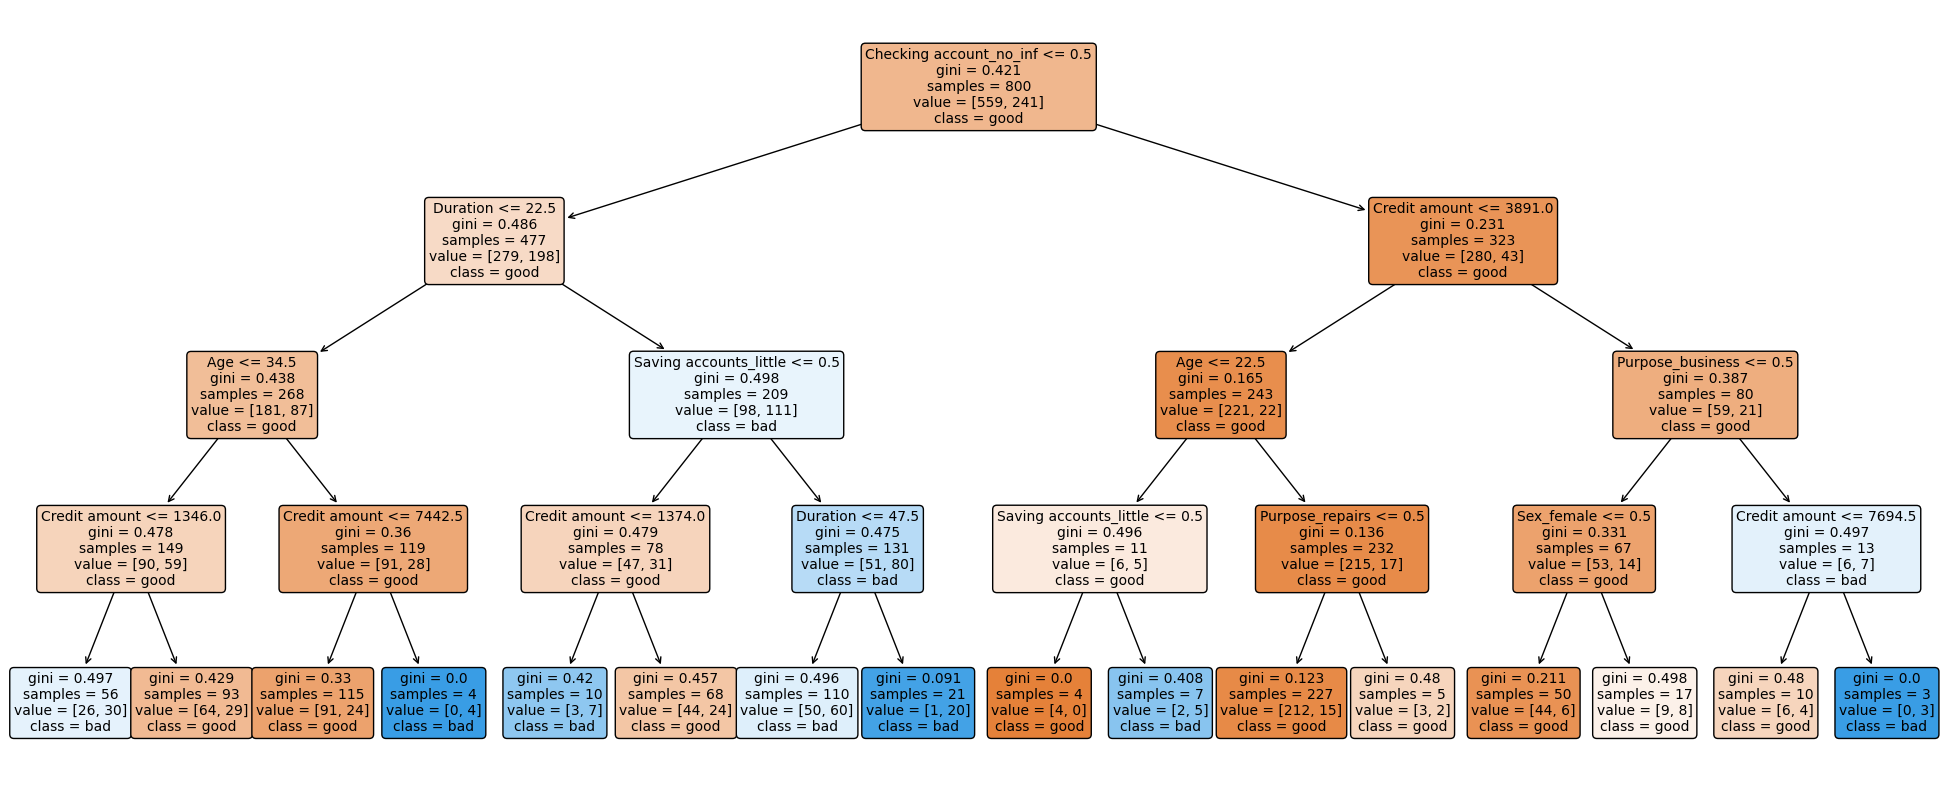

In [52]:
# plot tree
plt.figure(figsize=(25,10))  # set plot size (denoted in inches)
tree.plot_tree(model_DT, fontsize=10,
               feature_names=X_train.columns, class_names=['good','bad'],
               filled=True, rounded=True)
plt.show()

In [53]:
from sklearn.tree import export_text
r = export_text(model_DT, feature_names=list(X_train.columns))
print(r)

|--- Checking account_no_inf <= 0.50
|   |--- Duration <= 22.50
|   |   |--- Age <= 34.50
|   |   |   |--- Credit amount <= 1346.00
|   |   |   |   |--- class: True
|   |   |   |--- Credit amount >  1346.00
|   |   |   |   |--- class: False
|   |   |--- Age >  34.50
|   |   |   |--- Credit amount <= 7442.50
|   |   |   |   |--- class: False
|   |   |   |--- Credit amount >  7442.50
|   |   |   |   |--- class: True
|   |--- Duration >  22.50
|   |   |--- Saving accounts_little <= 0.50
|   |   |   |--- Credit amount <= 1374.00
|   |   |   |   |--- class: True
|   |   |   |--- Credit amount >  1374.00
|   |   |   |   |--- class: False
|   |   |--- Saving accounts_little >  0.50
|   |   |   |--- Duration <= 47.50
|   |   |   |   |--- class: True
|   |   |   |--- Duration >  47.50
|   |   |   |   |--- class: True
|--- Checking account_no_inf >  0.50
|   |--- Credit amount <= 3891.00
|   |   |--- Age <= 22.50
|   |   |   |--- Saving accounts_little <= 0.50
|   |   |   |   |--- class: False
|

Further reading:\
https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py


### Ensemble methods: Random Forrest Classifier

In [54]:
# import libraries
from sklearn.ensemble import RandomForestClassifier

In [55]:
# train the model
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [56]:
# predict on test data
y_pred = model_RF.predict(X_test)

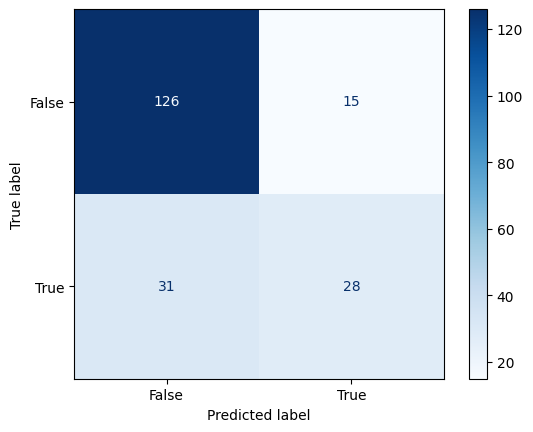

In [57]:
# Evaluate results based on the confusion matrix
plot_cm(y_test,y_pred)

In [58]:
# Evaluate model performance
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

       False       0.80      0.89      0.85       141
        True       0.65      0.47      0.55        59

    accuracy                           0.77       200
   macro avg       0.73      0.68      0.70       200
weighted avg       0.76      0.77      0.76       200



In [59]:
# Determine model robustness
roc_auc(model_RF, X_train, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6841
Cross-val ROC AUC mean : 0.7354
Cross-val ROC AUC std  : 0.0247


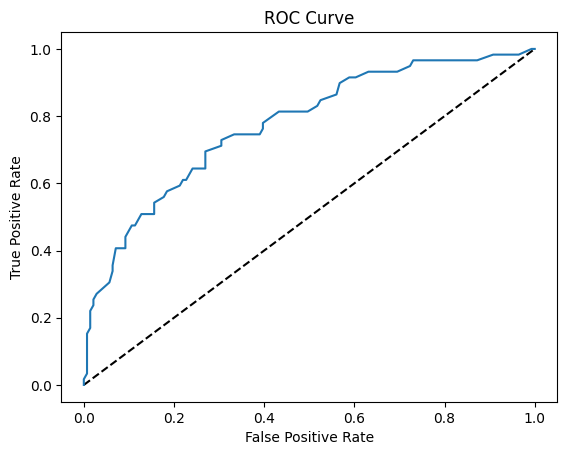

In [60]:
#Plotting the ROC curve
plot_roc_curve(model_RF, X_test, y_test)

### Ensemble methods: XGBoost Classifier

In [61]:
# import libraries
from xgboost import XGBClassifier

In [62]:
# train the model
model_XGB = XGBClassifier(random_state=42)
model_XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

https://xgboost.readthedocs.io/en/latest/parameter.html

In [63]:
# predict on test data
y_pred = model_XGB.predict(X_test)

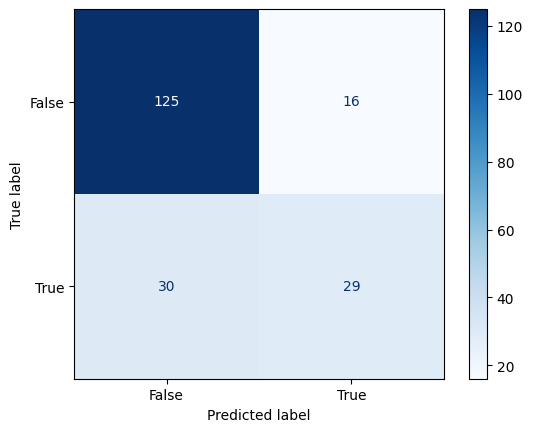

In [64]:
# Evaluate results based on the confusion matrix
plot_cm(y_test,y_pred)

In [65]:
# Evaluate model performance
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

       False       0.81      0.89      0.84       141
        True       0.64      0.49      0.56        59

    accuracy                           0.77       200
   macro avg       0.73      0.69      0.70       200
weighted avg       0.76      0.77      0.76       200



In [66]:
# Determine model robustness
roc_auc(model_XGB, X_train, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6890
Cross-val ROC AUC mean : 0.7310
Cross-val ROC AUC std  : 0.0399


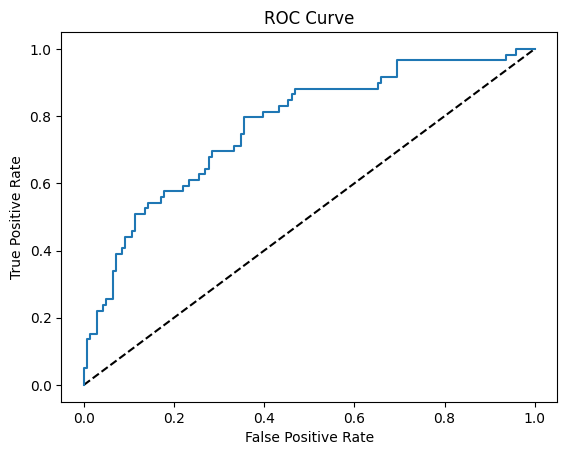

In [67]:
#Plotting the ROC curve
plot_roc_curve(model_XGB, X_test, y_test)

# **7. Model Selection** <a id="Model Selection"></a> <br>

In [68]:
def run_models(X_train, X_train_scaled, y_train, n_splits):
  # prepare models
  models = []
  model_names = ['LR','KNN','DT','RF','XGB']
  models.append(('Logistic Regression      ', model_LR))
  models.append(('KNeighbors Classifier    ', model_KNN))
  models.append(('Decision Tree Classifier ', model_DT))
  models.append(('Random Forest Classifier ', model_RF))
  models.append(('XGBoost Classifier       ', model_XGB))

  # evaluate each model in turn
  results = []
  names = []
  scoring = 'roc_auc'

  print('Model                     | ROC-AUC  | ROC-AUC std')
  for name, model in models:
    kfold = KFold(n_splits=n_splits)
    if name in ['DT', 'RF','XGB']:
      X_train_scaled = X_train
    cv_results = cross_val_score(model, X_train_scaled, y_train,
                                 cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s | %f | (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
  print('')

  # boxplot model comparison
  fig = plt.figure(figsize=(8,4))
  fig.suptitle('Models Performance Comparison')
  ax = fig.add_subplot(111)
  plt.boxplot(results)
  ax.set_xticklabels(model_names)
  plt.show()

Model                     | ROC-AUC  | ROC-AUC std
Logistic Regression       | 0.746925 | (0.040755)
KNeighbors Classifier     | 0.689318 | (0.069506)
Decision Tree Classifier  | 0.709819 | (0.057377)
Random Forest Classifier  | 0.726353 | (0.060961)
XGBoost Classifier        | 0.724921 | (0.063549)



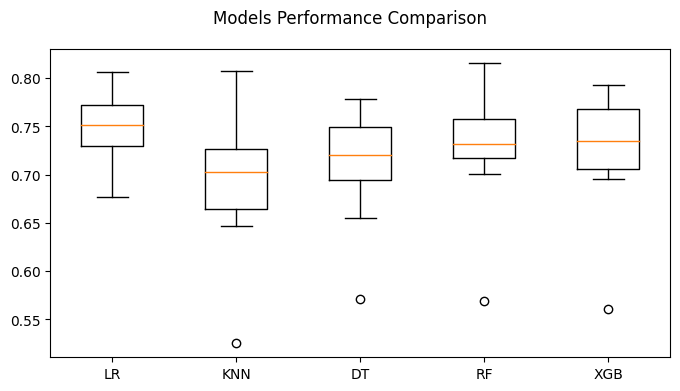

In [69]:
run_models(X_train, X_train_scaled, y_train,10)

# **8. Hyperparameter Tuning** <a id="Hyperparameter Tuning"></a> <br>

https://towardsdatascience.com/doing-xgboost-hyper-parameter-tuning-the-smart-way-part-1-of-2-f6d255a45dde

In [70]:
classifier = model_XGB
params = {"learning_rate"    : [ 0.05, 0.10, 0.15 ] ,
          "max_depth"        : [ 10, 12, 15],
          "min_child_weight" : [ 3, 5, 7 ],
          "gamma"            : [ 0.0, 0.1, 0.2 ],
          "colsample_bytree" : [ 0.3, 0.5 , 0.7 ] }

grid_search = GridSearchCV(classifier, param_grid=params, cv=5, scoring='roc_auc', n_jobs=32,verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=32,
             param_grid={'colsample_bytree': [0.3, 0.5, 0.7],
                         'gamma': [0.0, 0.1, 0.2],
                         'learning_rate': [0.05, 0.1, 0.15],
                         'max_depth': [10, 12, 15],
                         'min_child_weight': [3, 5, 7]},
             scoring='roc_auc', verbose=3)

In [71]:
print('Best score     :',grid_search.best_score_)
print('Best parameters:',grid_search.best_params_)
classifier = grid_search.best_estimator_

Best score     : 0.7624668194980695
Best parameters: {'colsample_bytree': 0.3, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 7}


In [72]:
# Predict results on test data
y_pred = classifier.predict(X_test)

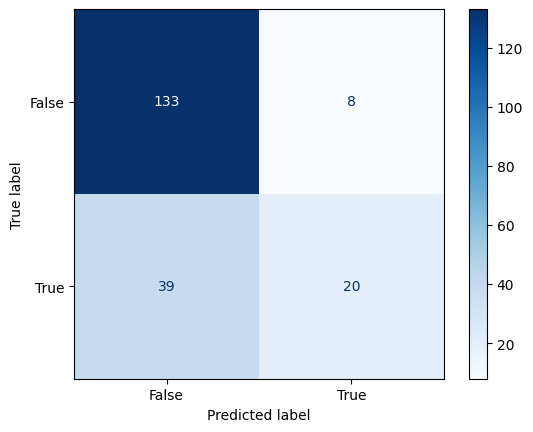

In [73]:
# Evaluate results based on the confusion matrix
plot_cm(y_test,y_pred)

In [74]:
# Evaluate model performance
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

       False       0.77      0.94      0.85       141
        True       0.71      0.34      0.46        59

    accuracy                           0.77       200
   macro avg       0.74      0.64      0.65       200
weighted avg       0.76      0.77      0.73       200



In [75]:
# Determine model robustness
roc_auc(classifier, X_train, y_train, y_test, y_pred, 5)

Test ROC AUC           : 0.6411
Cross-val ROC AUC mean : 0.7625
Cross-val ROC AUC std  : 0.0401


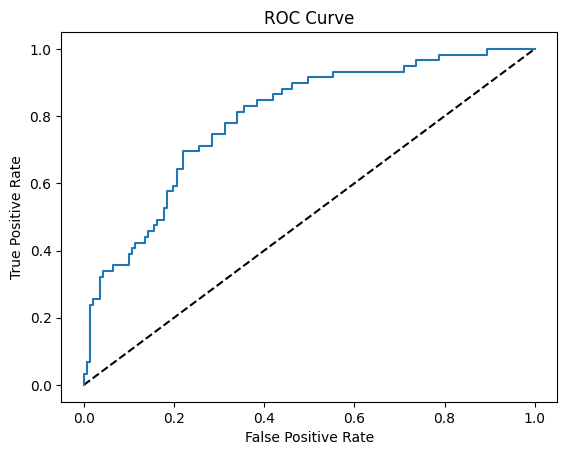

In [76]:
#Plotting the ROC curve
plot_roc_curve(classifier, X_test, y_test)

# **9. Classification Treshold Optimisation** <a id="Classification Treshold Optimisation"></a> <br>

### Define function to calculate treshold optimisation

In [77]:
def treshold_calc(new_treshold, classifier, X_test, y_test):
  y_pred = classifier.predict(X_test)
  y_pred_tr = ((classifier.predict_proba(X_test)[:, 1])>= new_treshold).astype(int)
  print('Valuation for test data only, standard treshold')
  print("Recall: %.4f" %recall_score(y_test,y_pred)," | ROC AUC: %.4f" %roc_auc_score(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  print("------------------------------------------------------")
  print('Valuation for test data only, treshold at', new_treshold)
  print("Recall: %.4f" % recall_score(y_test,y_pred_tr)," | ROC AUC: %.4f" % roc_auc_score(y_test, y_pred_tr))
  print(confusion_matrix(y_test, y_pred_tr))
  print(classification_report(y_test, y_pred_tr))

### Treshold optimisation on final model

In [78]:
from pylab import *

In [79]:
# predict probabilities
y_pred_proba = classifier.predict_proba(X_test)

In [80]:
# keep probabilities for the positive outcome only
probs = y_pred_proba[:, 1]

In [81]:
# define thresholds (test all thresholds between 0.0 and 1.0 with a step size of 0.001)
thresholds = arange(0, 1, 0.001)

In [82]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

In [83]:
# evaluate each threshold
scores = [roc_auc_score(y_test, to_labels(probs, t)) for t in thresholds]

In [84]:
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, ROC-AUC Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.245, ROC-AUC Score=0.73795


In [85]:
# Calculate results based on new treshold
treshold_calc(ix/1000, classifier, X_test, y_test)

Valuation for test data only, standard treshold
Recall: 0.3390  | ROC AUC: 0.6411
[[133   8]
 [ 39  20]]
              precision    recall  f1-score   support

       False       0.77      0.94      0.85       141
        True       0.71      0.34      0.46        59

    accuracy                           0.77       200
   macro avg       0.74      0.64      0.65       200
weighted avg       0.76      0.77      0.73       200

------------------------------------------------------
Valuation for test data only, treshold at 0.245
Recall: 0.8305  | ROC AUC: 0.7379
[[91 50]
 [10 49]]
              precision    recall  f1-score   support

       False       0.90      0.65      0.75       141
        True       0.49      0.83      0.62        59

    accuracy                           0.70       200
   macro avg       0.70      0.74      0.69       200
weighted avg       0.78      0.70      0.71       200



### Applying SMOTE to treat class imbalance

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [86]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state = 42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print('Before OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('Before OverSampling, the shape of y_train: {} \n'.format(y_train.shape))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, the shape of X_train: (800, 25)
Before OverSampling, the shape of y_train: (800,) 

Before OverSampling, counts of label '1': 241
Before OverSampling, counts of label '0': 559 

After OverSampling, the shape of X_train: (1118, 25)
After OverSampling, the shape of y_train: (1118,) 

After OverSampling, counts of label '1': 559
After OverSampling, counts of label '0': 559


In [87]:
# re-train the model
model_XGB_SMOTE = classifier
model_XGB_SMOTE.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [88]:
# Predict results on test data
y_pred = model_XGB_SMOTE.predict(X_test)

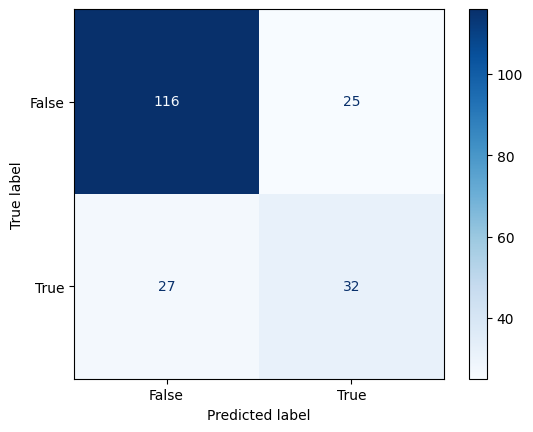

In [89]:
# Evaluate results based on the confusion matrix
plot_cm(y_test,y_pred)

In [90]:
# Evaluate model performance
clasif_report(y_test,y_pred)

              precision    recall  f1-score   support

       False       0.81      0.82      0.82       141
        True       0.56      0.54      0.55        59

    accuracy                           0.74       200
   macro avg       0.69      0.68      0.68       200
weighted avg       0.74      0.74      0.74       200



In [91]:
# Determine model robustness
roc_auc(model_XGB_SMOTE, X_train_res, y_train_res, y_test, y_pred, 5)

Test ROC AUC           : 0.6825
Cross-val ROC AUC mean : 0.8777
Cross-val ROC AUC std  : 0.1000


# **10. Model Explainability** <a id="Model Explainability"></a> <br>

https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html

In [94]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.7 MB/s eta 0:00:00


In [95]:
import shap
explainer = shap.Explainer(classifier)
shap_values = explainer(X_test)

### Global Interpretability

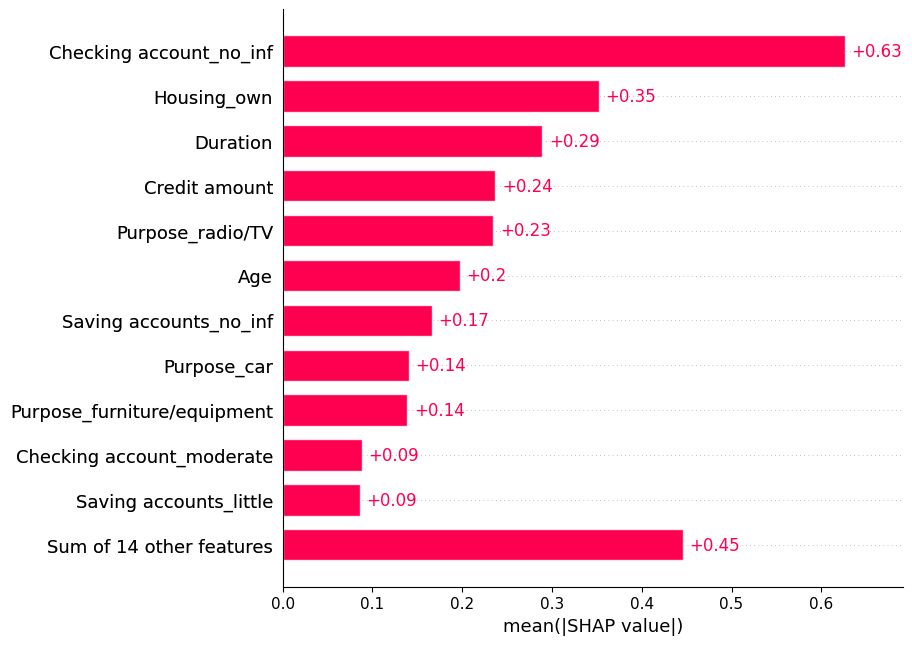

In [96]:
# Feature importance - bar plot
shap.plots.bar(shap_values, max_display=12) # default is max_display=12

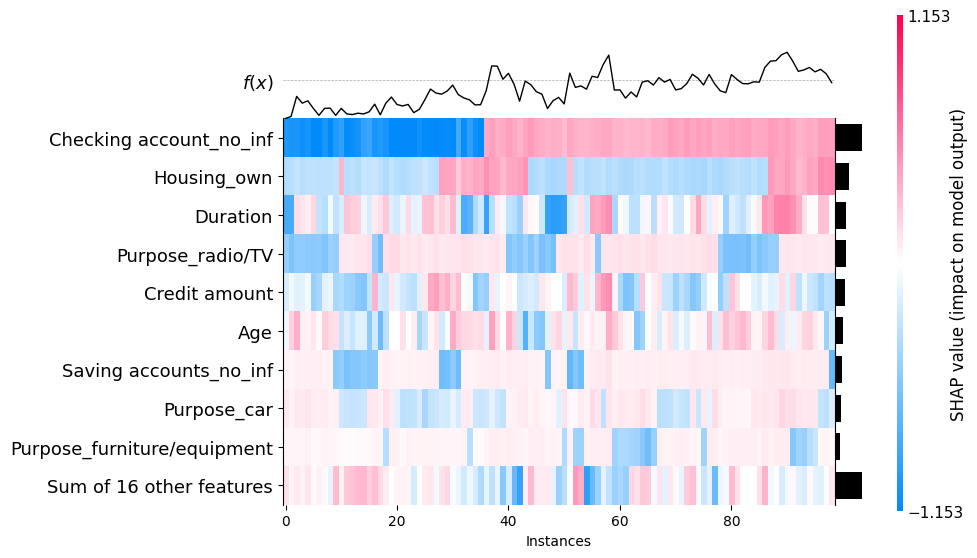

<Axes: xlabel='Instances'>

In [97]:
# Heatmap - first 100 examples
shap.plots.heatmap(shap_values[1:100])

In [100]:
# Feature importance and contribution - violin plot
#shap.summary_plot(explainer.shap_values(X_test), X_test, plot_type="violin")

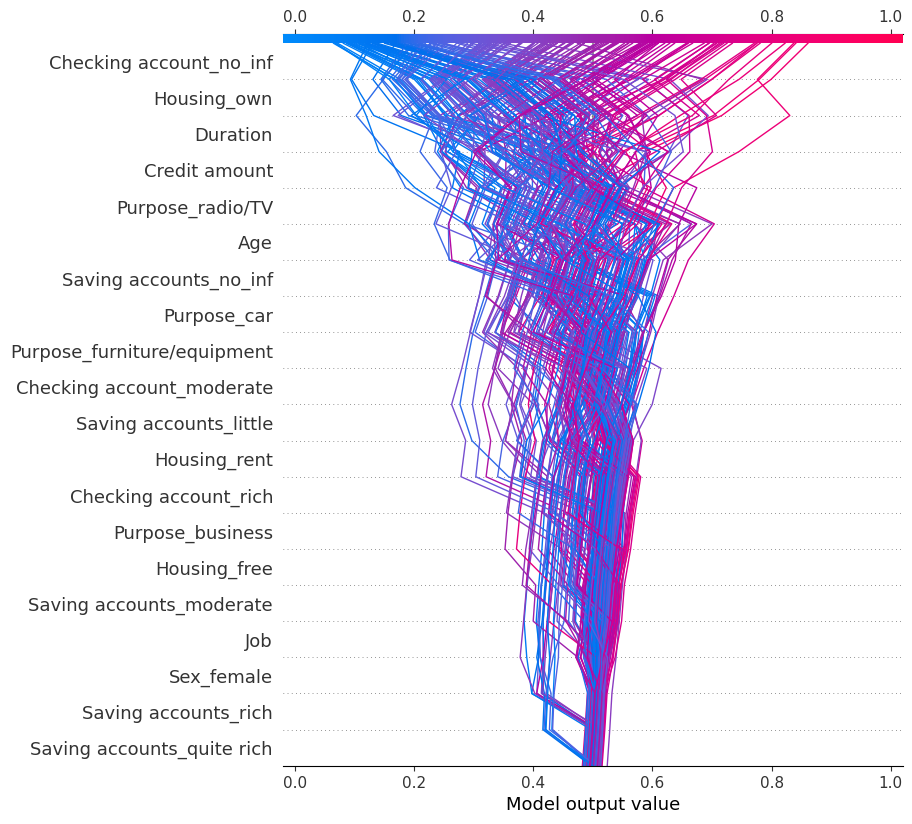

In [101]:
# Shap decision plot
r = shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test),  X_test,
                       return_objects=True, link='logit',ignore_warnings=True)

### Local Interpretability

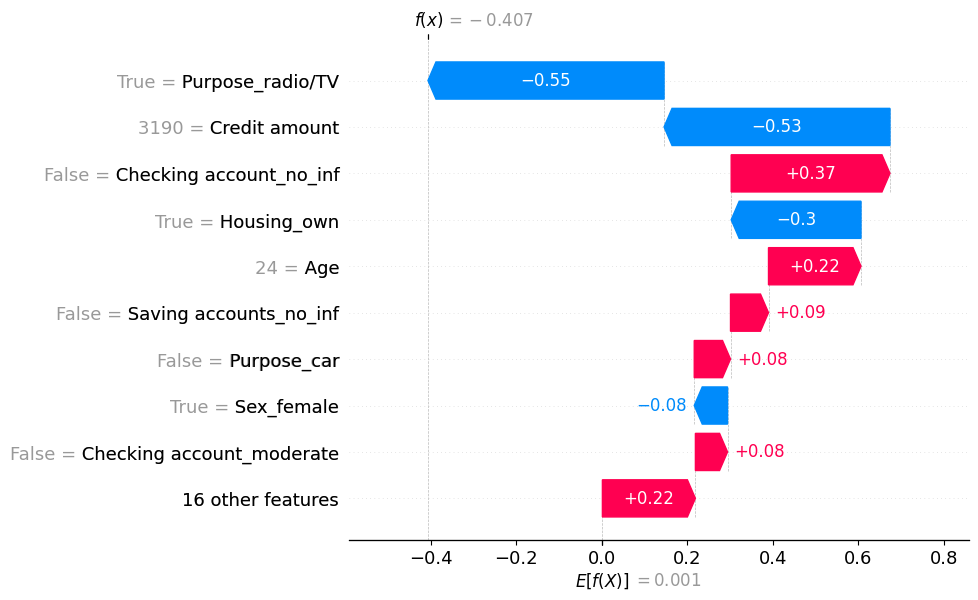

In [109]:
# Individual waterfall plot
id=0
explainer = shap.Explainer(classifier)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[id]) # For the first observation

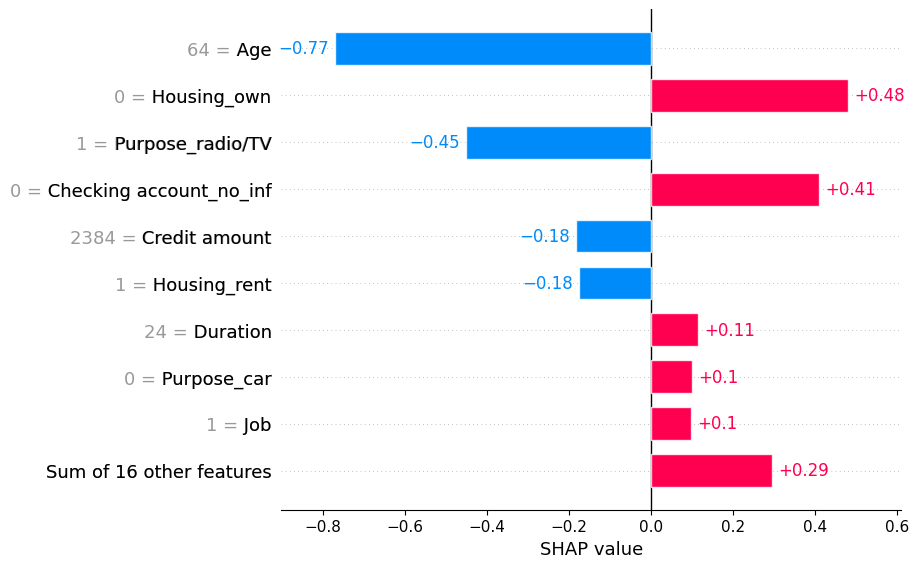

In [110]:
# Individual bar plot
id = 5
shap.plots.bar(shap_values[id]) # For the first observation

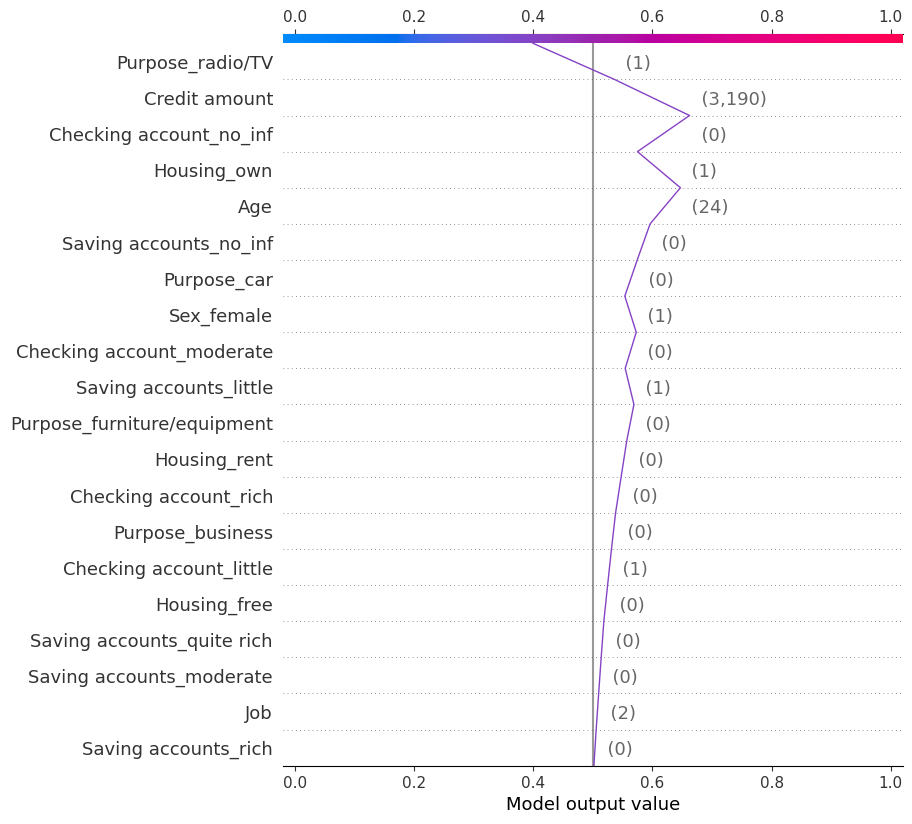

In [111]:
# Individual decision plot
id = 0
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[id,:], X_test.iloc[id,:], link='logit')

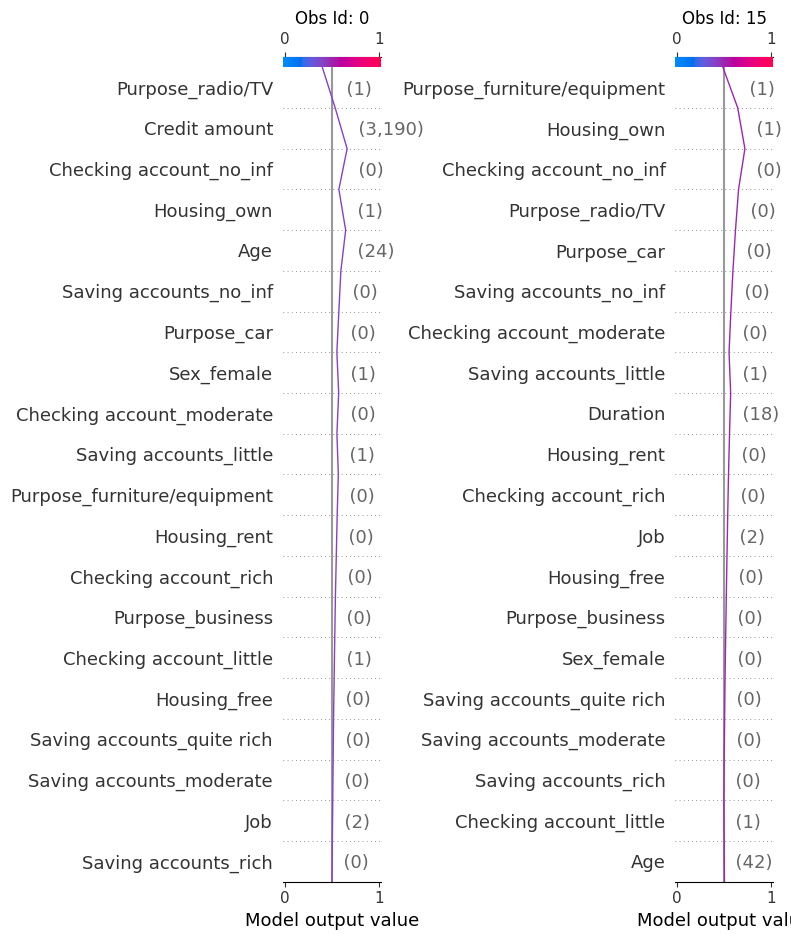

In [112]:
# Individual decision plot comparison for two observations
id1=0
id2=15

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[id1,:],
                   X_test.iloc[id1,:], show=False, link='logit')
ax1.title.set_text('Obs Id: '+str(id1))
ax2 = fig.add_subplot(122)
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[id2,:],
                   X_test.iloc[id2,:], show=False, link='logit')
ax2.title.set_text('Obs Id: '+str(id2))
plt.tight_layout()
plt.show()

In [113]:
# Individual force plot
shap.initjs()
id=3
shap.force_plot(explainer.expected_value, explainer.shap_values(X_test)[id,:], X_test.iloc[id,:], link='logit')

In [114]:
# Interactive general force plot
shap.initjs()
shap.force_plot(explainer.expected_value, explainer.shap_values(X_test), X_test, link='logit')

In [115]:
# Dependence plots
X_test.columns

Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female', 'Housing_free',
       'Housing_own', 'Housing_rent', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_no_inf',
       'Saving accounts_quite rich', 'Saving accounts_rich',
       'Checking account_little', 'Checking account_moderate',
       'Checking account_no_inf', 'Checking account_rich', 'Purpose_business',
       'Purpose_car', 'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others'],
      dtype='object')

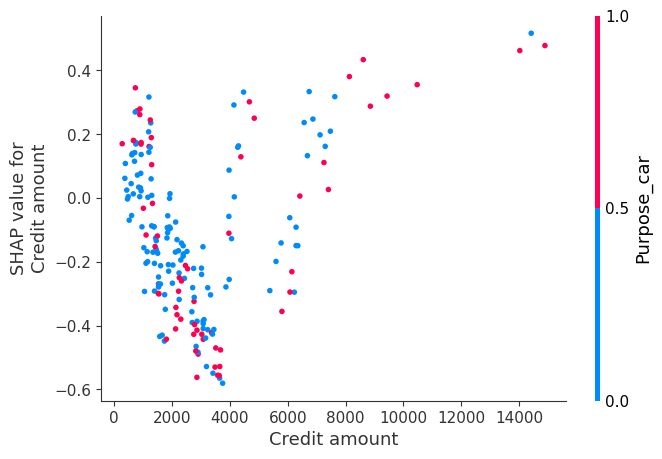

In [116]:
# Dependence plots based on a feature with automatic interaction feature
feature = "Credit amount"
shap.dependence_plot(feature, explainer.shap_values(X_test), X_test)

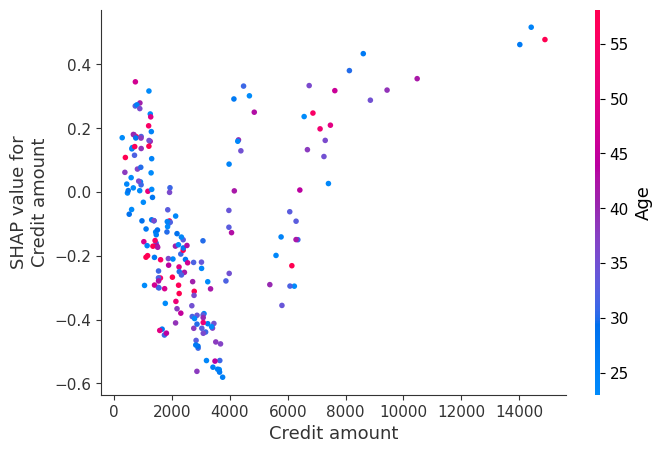

In [117]:
# Dependence plots based on a feature with defined interaction feature
feature = "Credit amount"
interaction_feature = "Age"
shap.dependence_plot(feature, explainer.shap_values(X_test), X_test, interaction_index=interaction_feature)

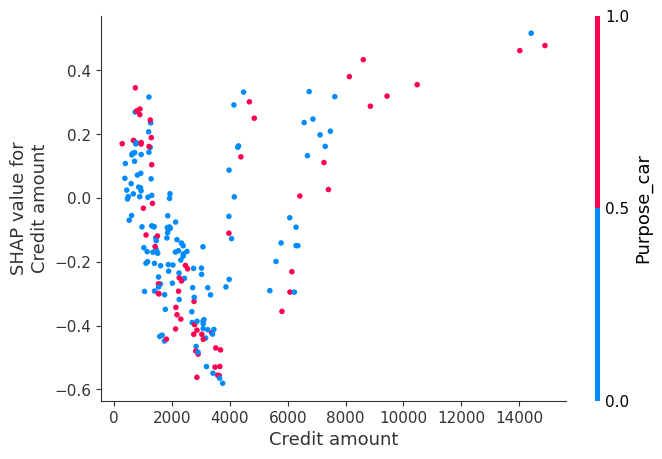

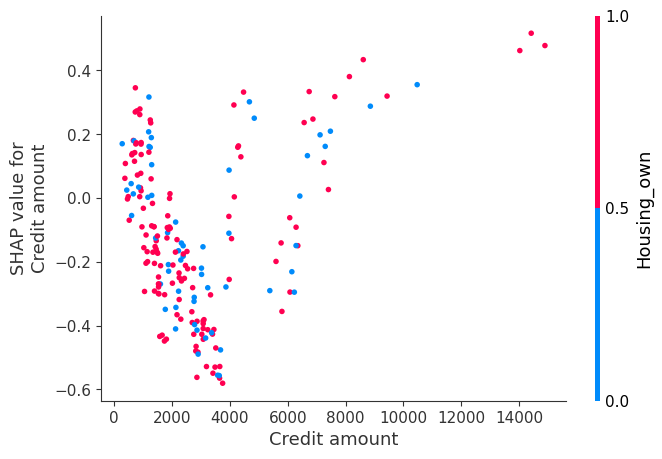

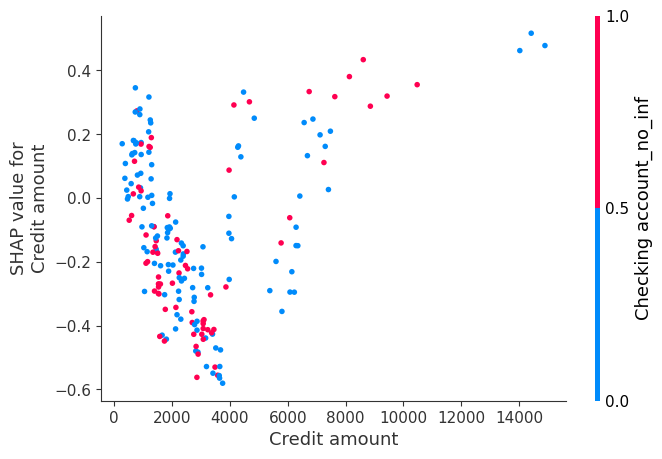

In [118]:
# use approximate_interactions to guess top three possible interactions
feature = "Credit amount"
inds = shap.approximate_interactions(feature, explainer.shap_values(X_test), X_test)

# make plots colored by each of the top three possible interacting features
for i in range(3):
    shap.dependence_plot(feature, explainer.shap_values(X_test), X_test, interaction_index=inds[i])